In [127]:
## 라이브러리 불러오기

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
import seaborn as sns

In [2]:
# 데이터 불러오기
data = pd.read_csv('total_data.csv', encoding='euc-kr')

In [3]:
data= data.iloc[:,1:]
data.head()

,자치구,연도,기초생활보장수급자 인원(명),유통업체 개소,생활폐기물 배출량 (t/일),생활폐기물 재활용량,비만율,가정용도시가스이용량,시민행복지수 종합,식품접객업 수,급식소 수,인구수,면적(㎢),인구밀도(명/㎢),시가화면적비율 (%),시가화면적 (㎢),집단급식소,식품제조업 및 가공업,식품 운반·판매·기타업,음식물 쓰레기 발생량(t/일)
0,종로구,2020,5232,13,264.2,77.4,28.7,74329,6.46,9268,192,158996,23.91,6649,53.39,12.77,192,436,149,76.1
1,중구,2020,5299,53,357.5,117.9,26.2,4839,6.44,9110,194,134635,9.96,13517,99.89,9.95,194,476,420,80.8
2,용산구,2020,8265,13,301.2,133.6,25.5,1244,6.30,6059,156,244645,21.87,11188,61.14,13.37,156,453,350,63.7
3,성동구,2020,9718,13,301.2,123.7,29.6,1821,6.38,5062,200,300505,16.86,17822,73.98,12.47,200,581,488,77.9
4,광진구,2020,11864,19,343.1,152.0,25.1,8892,6.38,5945,178,360109,17.06,21105,69.16,11.80,178,524,392,86.8


## 시각화 코드 

In [118]:
def plot_feature_importance(importance,names,model_type):

    plt.rc('font',family='Malgun Gothic')
    sns.set(font='Malgun Gothic', rc={'axes.unicode_minus':False}, style='darkgrid')

    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)


    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)


    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [15]:
def make_pred_obv_plot(y_test,y_train,predict_test,predict_train,title):
    from matplotlib.offsetbox import AnchoredText
    test_r2 = round(r2_score(y_test, predict_test),3)
    train_r2 =round(r2_score(y_train, predict_train),3)
    total_data = pd.concat([y_test,y_train])
    total_pred = np.concatenate([predict_test,predict_train])
    total_r2 = round(r2_score(total_data,total_pred),3)
    
    print(test_r2, 'test r-squared')
    print(train_r2, 'train r-squared')
    
    print(sqrt(mean_squared_error(y_test, predict_test)), 'test RMSE')
    print(sqrt(mean_squared_error(y_train, predict_train)), 'train RMSE')
    
    fig, ax = plt.subplots(figsize=(5,5))

    ax.scatter(y_train,predict_train,label='train',alpha=.5, marker='o', facecolor='none',edgecolors='b')
    ax.scatter(y_test,predict_test, label='test', alpha=.5, marker='s',color = 'red')    
    ## lim 설정
    lims = [np.min([ax.get_xlim(),ax.get_ylim()]), np.max([ax.get_xlim(),ax.get_ylim()])]
    ax.plot(lims,lims,zorder=0, color = 'black')
    ax.set_xlim(lims)
    ax.set_xlabel('Obv')
    ax.set_ylabel('Pred')
    ax.set_ylim(lims)
    ax.legend()
    ax.set_title(title)
    text = 'Train R-squared : ' + str(train_r2) + '\nTest R-squared : '+str(test_r2)+'\nOverall R-squared : ' +str(total_r2)
    anchored_text = AnchoredText(text,loc=4)
    ax.add_artist(anchored_text)

# EDA

In [109]:
def make_part(x):
    if x == '종로구' or x == '중구' or x=='용산구':
        return '도심권'
    elif x == '성동구' or x=='성북구' or x=='광진구' or x=='강북구':
        return '동북권'
        
    elif x == '은평구' or x=='서대문구' or x=='마포구':
        return '서북권'
        
    elif x == '양천구' or x=='영등포구' or x=='강서구' or x=='동작구':
        return '서남권'
        
    else:
        return '동남권'
        
data['권역'] = data['자치구'].apply(make_part)

In [110]:
big_data = data.groupby('권역').mean()
big_data

,연도,기초생활보장수급자 인원(명),유통업체 개소,생활폐기물 재활용량,비만율,가정용도시가스이용량,시민행복지수 종합,식품접객업 수,인구수,면적(㎢),인구밀도(명/㎢),시가화면적비율 (%),시가화면적 (㎢),집단급식소,식품제조업 및 가공업,식품 운반·판매·기타업,음식물 쓰레기 발생량(t/일)
권역,,,,,,,,,,,,,,,,,
도심권,2015.0,4640.939394,24.757576,122.451515,24.900000,73670.575758,6.715303,7243.424242,184571.181818,18.580000,10720.909091,71.151212,11.954848,172.969697,351.212121,618.515152,102.778788
동남권,2015.0,11094.479339,17.471074,148.971074,25.897521,166126.570248,6.833099,6439.867769,463956.512397,26.954463,18598.677686,61.966364,15.582231,252.330579,725.702479,827.768595,139.741322
동북권,2015.0,9924.227273,13.000000,113.731818,25.897727,139086.909091,6.709091,4665.318182,372298.727273,20.522727,18411.477273,64.992273,13.156364,196.545455,476.113636,485.340909,92.188636
서남권,2015.0,11729.340909,14.477273,113.106818,25.402273,169208.977273,6.855909,5942.318182,476283.795455,24.934318,21085.954545,69.900000,15.825227,264.340909,613.840909,622.931818,139.572727
서북권,2015.0,10348.000000,11.757576,105.557576,25.442424,147952.666667,6.798333,6431.787879,404076.636364,23.721212,17183.939394,66.210606,14.957576,209.090909,487.030303,443.575758,93.730303


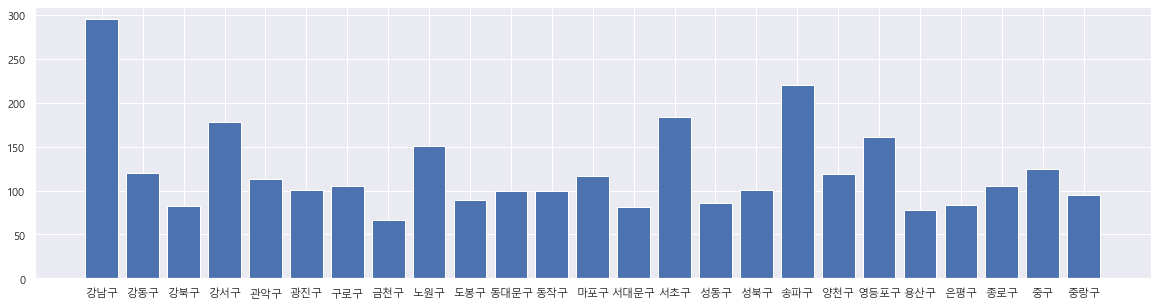

In [111]:
group_data = data.groupby('자치구').mean()
plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False


plt.figure(figsize=(20, 5))
plt.bar(group_data.index, group_data['음식물 쓰레기 발생량(t/일)'])
sns.set(font_scale=1)

In [112]:
group_data

,연도,기초생활보장수급자 인원(명),유통업체 개소,생활폐기물 재활용량,비만율,가정용도시가스이용량,시민행복지수 종합,식품접객업 수,인구수,면적(㎢),인구밀도(명/㎢),시가화면적비율 (%),시가화면적 (㎢),집단급식소,식품제조업 및 가공업,식품 운반·판매·기타업,음식물 쓰레기 발생량(t/일)
자치구,,,,,,,,,,,,,,,,,
강남구,2015.0,11047.000000,26.363636,234.990909,21.072727,209283.090909,6.964545,15268.090909,566303.363636,39.501818,14335.545455,63.742727,25.180909,387.545455,980.727273,1858.181818,295.145455
강동구,2015.0,9170.363636,12.090909,117.090909,26.236364,160740.818182,6.747727,5272.272727,467994.818182,24.589091,19033.545455,56.222727,13.847273,250.636364,664.090909,533.909091,119.518182
강북구,2015.0,13835.272727,11.000000,72.681818,27.136364,122979.545455,6.674091,4477.363636,333716.545455,23.600909,14140.909091,44.096364,10.408182,165.909091,504.000000,505.000000,82.890909
강서구,2015.0,20546.272727,16.181818,157.400000,25.636364,204867.181818,6.690000,6664.454545,590079.090909,41.435455,14242.090909,44.746364,18.537273,336.090909,672.000000,745.909091,177.900000
관악구,2015.0,13013.636364,16.181818,114.063636,25.845455,216000.181818,6.910000,5916.363636,529676.181818,29.570000,17913.272727,47.300909,13.989091,211.272727,607.000000,505.181818,112.981818
광진구,2015.0,7146.545455,15.545455,159.854545,24.081818,149621.727273,6.695909,5259.545455,376023.363636,17.060000,22037.363636,68.546364,11.695455,174.636364,511.363636,439.727273,100.154545
구로구,2015.0,8008.181818,23.727273,61.500000,27.190909,159370.727273,6.900455,5246.181818,448314.545455,20.120000,22282.090909,72.945455,14.676364,245.545455,537.090909,559.545455,104.900000
금천구,2015.0,9005.363636,13.181818,90.990909,27.590909,99579.000000,6.775455,3909.545455,256709.636364,13.014545,19725.272727,79.250000,10.315455,197.363636,355.454545,334.090909,66.790909
노원구,2015.0,24318.090909,14.272727,115.000000,26.836364,185366.181818,6.772273,4782.909091,574945.636364,35.440000,16224.454545,39.403636,13.965455,292.909091,665.545455,539.272727,151.090909


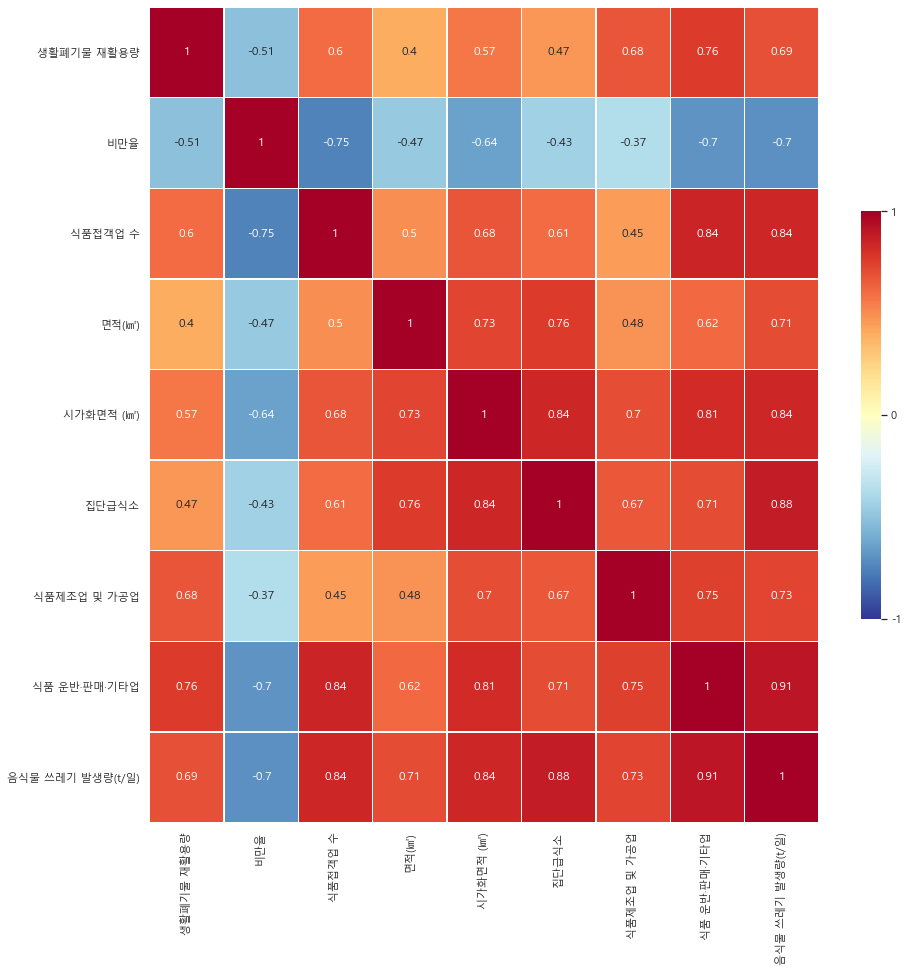

In [114]:
df = group_data.loc[:,[  '생활폐기물 재활용량',
       '비만율',   '식품접객업 수',  '면적(㎢)',
         '시가화면적 (㎢)', '집단급식소', '식품제조업 및 가공업',
       '식품 운반·판매·기타업', '음식물 쓰레기 발생량(t/일)']].corr()
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')
plt.figure(figsize = ( 15,15))
sns.heatmap(df, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1,   # 컬러바 범위 -1 ~ 1,
            
           )  
sns.set(font_scale=5)

# Train, Test

In [122]:
x_data = data.iloc[:,2:-2]
y_data = data.iloc[:,-2]

In [123]:
x_train, x_test, y_train,y_test = train_test_split(x_data,y_data, test_size = 0.2, random_state =42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# RandomForest

## grid search 사용

In [278]:
model = RandomForestRegressor()

h_para = {'max_depth':[1,2,3,4,5], "n_estimators": [200,300,500,1000]}

grid_rf = GridSearchCV(model, param_grid=h_para,
                         cv=5, refit=True, return_train_score=True)

grid_rf.fit(x_train_scaled, y_train)


scores_df = pd.DataFrame(grid_rf.cv_results_)


scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'n_estimators': 200}",0.680285,19,0.663278,0.681541,0.703306
1,"{'max_depth': 1, 'n_estimators': 300}",0.678202,20,0.659849,0.675464,0.701759
2,"{'max_depth': 1, 'n_estimators': 500}",0.683003,17,0.658855,0.686426,0.708293
3,"{'max_depth': 1, 'n_estimators': 1000}",0.682217,18,0.655231,0.682115,0.704169
4,"{'max_depth': 2, 'n_estimators': 200}",0.810390,13,0.852163,0.852883,0.808833
5,"{'max_depth': 2, 'n_estimators': 300}",0.806024,15,0.845754,0.845165,0.805382
6,"{'max_depth': 2, 'n_estimators': 500}",0.807781,14,0.853758,0.850153,0.807657
7,"{'max_depth': 2, 'n_estimators': 1000}",0.804984,16,0.847557,0.840547,0.802599
8,"{'max_depth': 3, 'n_estimators': 200}",0.865545,10,0.903621,0.908155,0.864362
9,"{'max_depth': 3, 'n_estimators': 300}",0.862720,12,0.897409,0.901854,0.863946


In [279]:
print(f"최적의 파라미터 : {grid_rf.best_params_}")
print(f"최적의 파라미터로 모델의 정확도 : {grid_rf.best_score_}")


최적의 파라미터 : {'max_depth': 5, 'n_estimators': 500}
최적의 파라미터로 모델의 정확도 : 0.9139474380258454


In [125]:
from sklearn.metrics import r2_score
model = RandomForestRegressor(max_depth=5, n_estimators = 500)
model.fit(x_train_scaled,y_train)
print(r2_score(y_test,model.predict(x_test_scaled)))

0.9075771033068964


0.908 test r-squared
0.979 train r-squared
13.579996061612853 test RMSE
7.880105839484584 train RMSE


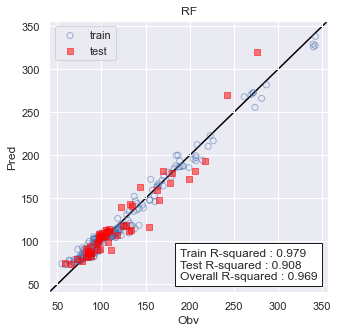

In [129]:
rf_predict = model.predict(x_test_scaled)
rf_train_predict = model.predict(x_train_scaled)

## XGBoost
sns.set(font_scale=1)
make_pred_obv_plot(y_test,y_train,rf_predict,rf_train_predict,'RF')


In [181]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train, rf_train_predict)

6.238402863434477

In [189]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, rf_predict)

9.923851938128523

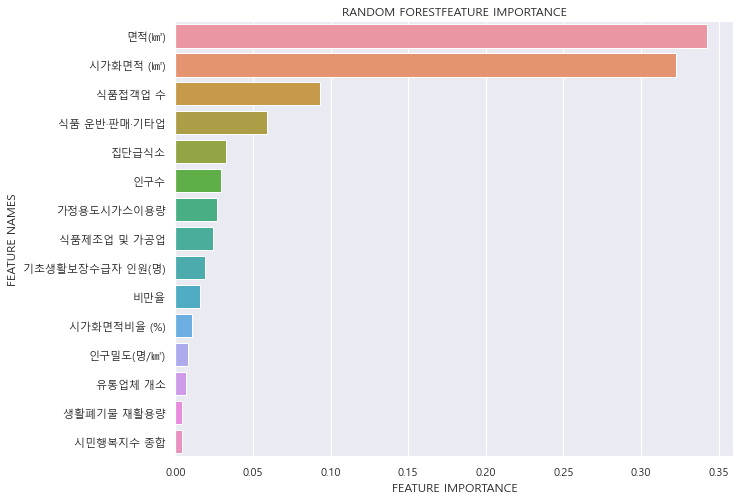

In [132]:
plt.rc('font',family='Malgun Gothic')
sns.set(font='Malgun Gothic', rc={'axes.unicode_minus':False}, style='darkgrid')

plot_feature_importance(model.feature_importances_,x_train.columns,'RANDOM FOREST')

# XGBoost

In [195]:
model = XGBRegressor()
# parameter 넣어줄 값들 dict 형태로 정의해주기
h_para = {'eta':[0.001,0.01,0.1],'max_depth':[3,6,9,12], "n_estimators": [100,200,300], 'subsample':[0.2,0.3]}

grid_xgb = GridSearchCV(model, param_grid=h_para,
                         cv=5, refit=True, return_train_score=True)
# GridSearchCV 인자설명
# cv = 하나의 파라미터 쌍으로 모델링할 때 train, test 교차검증을 3번실시하겠다는 뜻
# refit=True : GridSearch한 후 가장 최고로 좋은 파라미터로 학습시켜 놓겠다.
# ㄴ> 이것 때문에 애초에 GridSearchCV 적용한 객체만으로 최적의 파라미터 적용된 모델로드 가능

# GridSearch 하면서 모든 파라미터값들에 대해 학습 수행
grid_xgb.fit(x_train, y_train)

# 각 파라미터값들에 대한 모델 결과값들이 cv_results_ 객체에 할당됨
scores_df = pd.DataFrame(grid_xgb.cv_results_)

# score 결과값(ndarray형태로 할당됨) 중 특정 칼럼들만 가져오기 
scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'eta': 0.001, 'max_depth': 3, 'n_estimators':...",-4.632654,69,-3.578123,-2.837283,-4.794546
1,"{'eta': 0.001, 'max_depth': 3, 'n_estimators':...",-4.598809,65,-3.565685,-2.814444,-4.763351
2,"{'eta': 0.001, 'max_depth': 3, 'n_estimators':...",-3.767361,61,-2.884344,-2.339624,-3.836968
3,"{'eta': 0.001, 'max_depth': 3, 'n_estimators':...",-3.709853,57,-2.862169,-2.294091,-3.790288
4,"{'eta': 0.001, 'max_depth': 3, 'n_estimators':...",-3.041544,53,-2.299343,-1.909419,-3.055956
...,...,...,...,...,...,...
67,"{'eta': 0.1, 'max_depth': 12, 'n_estimators': ...",0.912620,20,0.927444,0.959624,0.896622
68,"{'eta': 0.1, 'max_depth': 12, 'n_estimators': ...",0.916691,14,0.928250,0.952852,0.909921
69,"{'eta': 0.1, 'max_depth': 12, 'n_estimators': ...",0.922776,3,0.933756,0.967012,0.904572
70,"{'eta': 0.1, 'max_depth': 12, 'n_estimators': ...",0.920494,9,0.928872,0.958052,0.911835


In [196]:
print(f"최적의 파라미터 : {grid_xgb.best_params_}")
print(f"최적의 파라미터로 모델의 정확도 : {grid_xgb.best_score_}")


최적의 파라미터 : {'eta': 0.1, 'max_depth': 12, 'n_estimators': 300, 'subsample': 0.3}
최적의 파라미터로 모델의 정확도 : 0.9240815152035371


0.9261045198939046
0.926 test r-squared
1.0 train r-squared
12.142798647751004 test RMSE
0.22732068771565322 train RMSE


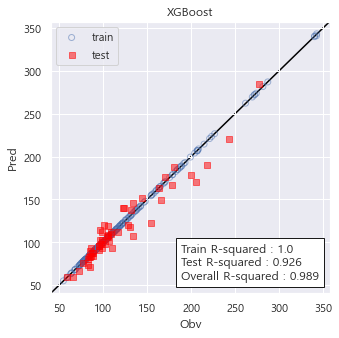

In [142]:
xgb = XGBRegressor(eta=0.1 , max_depth = 8, n_estimators=200, subsample=0.5)
xgb.fit(x_train_scaled,y_train.values.ravel())

print(xgb.score(x_test_scaled, y_test))

xgb_predict = xgb.predict(x_test_scaled)
xgb_train_predict = xgb.predict(x_train_scaled)

## XGBoost

make_pred_obv_plot(y_test,y_train,xgb_predict,xgb_train_predict,'XGBoost')

## 과적합 막기

In [18]:
# XGBoost 의 경우 Train R-squared가 1.0 으로 과적합이 되는 것을 확인하여
# alpha와 max_depth 를 사용하여 Train 성능을 줄이고 Test 성능을 높였다.

0.922 test r-squared
0.929 train r-squared
12.514350073775974 test RMSE
14.633769078288458 train RMSE


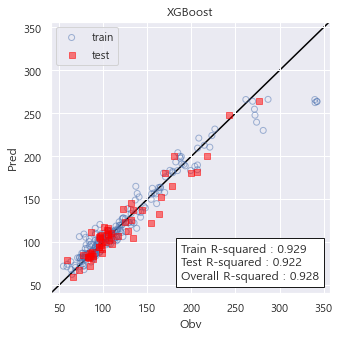

In [159]:
xgb = XGBRegressor(eta=0.1 , max_depth = 3, n_estimators=300, subsample=0.5, alpha=400)
## alpha를 통해 규제 
xgb.fit(x_train_scaled,y_train.values.ravel())

#print(xgb.score(x_test_scaled, y_test))

xgb_predict = xgb.predict(x_test_scaled)
xgb_train_predict = xgb.predict(x_train_scaled)

## XGBoost

make_pred_obv_plot(y_test,y_train,xgb_predict,xgb_train_predict,'XGBoost')

In [160]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, xgb_predict)

9.535320601029829

In [180]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train, xgb_train_predict)

8.826739030317826

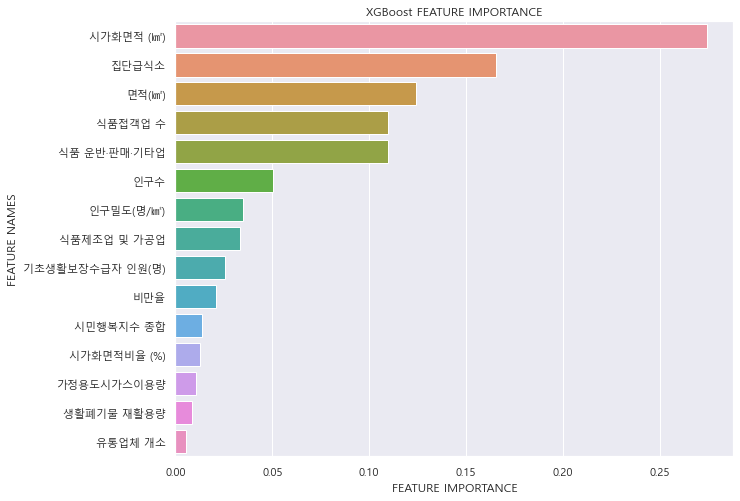

In [161]:
plot_feature_importance(xgb.feature_importances_,x_train.columns,'XGBoost ')

# SVM

In [177]:
import sklearn.svm as svm

svm = svm.SVR(kernel='linear')
svm.fit(x_train_scaled,y_train.values.ravel())

score = svm.score(x_test_scaled,y_test)
print(score)

0.8569038971048094


0.857 test r-squared
0.878 train r-squared
16.897550737727816 test RMSE
19.149814318298645 train RMSE


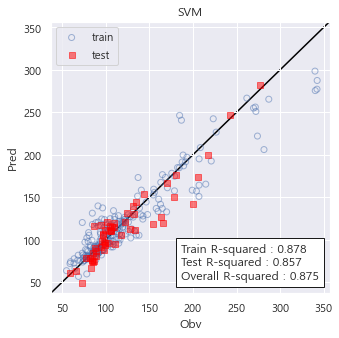

In [178]:
svm_predict = svm.predict(x_test_scaled)
svm_train_predict = svm.predict(x_train_scaled)

## XGBoost

make_pred_obv_plot(y_test,y_train,svm_predict,svm_train_predict,'SVM')

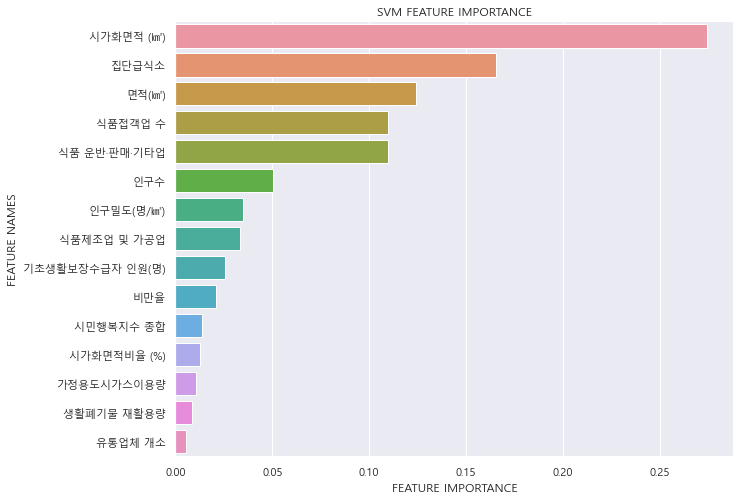

In [170]:
plot_feature_importance(xgb.feature_importances_,x_train.columns,'SVM ')

In [184]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, svm_predict)

12.047500862801261

In [185]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train, svm_train_predict)

12.672470622177567

# ANN

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization

In [246]:
model = Sequential()
model.add(Dense(10,input_shape=(17,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 10)                180       
                                                                 
 dense_17 (Dense)            (None, 256)               2816      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                32832     
                                                                 
 dense_20 (Dense)            (None, 1)                

In [247]:
model.compile(loss='mse',optimizer='adam',metrics=['mse'])

In [248]:
history = model.fit(x_train_scaled,y_train.values.ravel(), epochs=500, batch_size=1)

Epoch 1/500
220/220 [==============================] - 1s 2ms/step - loss: 5466.2886 - mse: 5466.2886
Epoch 2/500
220/220 [==============================] - 0s 2ms/step - loss: 833.7662 - mse: 833.7662
Epoch 3/500
220/220 [==============================] - 0s 2ms/step - loss: 791.7556 - mse: 791.7556
Epoch 4/500
220/220 [==============================] - 0s 2ms/step - loss: 641.7104 - mse: 641.7104
Epoch 5/500
220/220 [==============================] - 0s 2ms/step - loss: 561.2255 - mse: 561.2255
Epoch 6/500
220/220 [==============================] - 0s 2ms/step - loss: 540.0107 - mse: 540.0107
Epoch 7/500
220/220 [==============================] - 0s 2ms/step - loss: 638.2590 - mse: 638.2590
Epoch 8/500
220/220 [==============================] - 0s 2ms/step - loss: 749.0982 - mse: 749.0982
Epoch 9/500
220/220 [==============================] - 0s 2ms/step - loss: 453.9764 - mse: 453.9764
Epoch 10/500
220/220 [==============================] - 0s 2ms/step - loss: 663.5525 - mse: 663.55

220/220 [==============================] - 0s 2ms/step - loss: 183.6402 - mse: 183.6402
Epoch 163/500
220/220 [==============================] - 0s 2ms/step - loss: 230.2771 - mse: 230.2771
Epoch 164/500
220/220 [==============================] - 0s 2ms/step - loss: 181.3864 - mse: 181.3864
Epoch 165/500
220/220 [==============================] - 0s 2ms/step - loss: 190.5987 - mse: 190.5987
Epoch 166/500
220/220 [==============================] - 0s 2ms/step - loss: 224.2626 - mse: 224.2626
Epoch 167/500
220/220 [==============================] - 0s 2ms/step - loss: 245.7825 - mse: 245.7825
Epoch 168/500
220/220 [==============================] - 0s 2ms/step - loss: 192.8501 - mse: 192.8501
Epoch 169/500
220/220 [==============================] - 0s 2ms/step - loss: 211.9201 - mse: 211.9201
Epoch 170/500
220/220 [==============================] - 0s 2ms/step - loss: 219.5528 - mse: 219.5528
Epoch 171/500
220/220 [==============================] - 0s 2ms/step - loss: 249.5352 - mse: 249

220/220 [==============================] - 1s 2ms/step - loss: 159.3692 - mse: 159.3692
Epoch 323/500
220/220 [==============================] - 0s 2ms/step - loss: 160.7940 - mse: 160.7940
Epoch 324/500
220/220 [==============================] - 0s 2ms/step - loss: 168.8326 - mse: 168.8326
Epoch 325/500
220/220 [==============================] - 0s 2ms/step - loss: 227.1401 - mse: 227.1401
Epoch 326/500
220/220 [==============================] - 0s 2ms/step - loss: 255.8082 - mse: 255.8082
Epoch 327/500
220/220 [==============================] - 0s 2ms/step - loss: 164.6351 - mse: 164.6351
Epoch 328/500
220/220 [==============================] - 0s 2ms/step - loss: 182.0401 - mse: 182.0401
Epoch 329/500
220/220 [==============================] - 0s 2ms/step - loss: 167.4135 - mse: 167.4135
Epoch 330/500
220/220 [==============================] - 0s 2ms/step - loss: 164.4490 - mse: 164.4490
Epoch 331/500
220/220 [==============================] - 1s 2ms/step - loss: 155.6182 - mse: 155

220/220 [==============================] - 0s 2ms/step - loss: 138.0154 - mse: 138.0154
Epoch 483/500
220/220 [==============================] - 0s 2ms/step - loss: 185.0071 - mse: 185.0071
Epoch 484/500
220/220 [==============================] - 0s 2ms/step - loss: 163.3880 - mse: 163.3880
Epoch 485/500
220/220 [==============================] - 0s 2ms/step - loss: 152.8173 - mse: 152.8173
Epoch 486/500
220/220 [==============================] - 0s 2ms/step - loss: 142.8814 - mse: 142.8814
Epoch 487/500
220/220 [==============================] - 0s 2ms/step - loss: 128.1397 - mse: 128.1397
Epoch 488/500
220/220 [==============================] - 0s 2ms/step - loss: 183.4762 - mse: 183.4762
Epoch 489/500
220/220 [==============================] - 0s 2ms/step - loss: 80.3167 - mse: 80.3167
Epoch 490/500
220/220 [==============================] - 0s 2ms/step - loss: 144.3036 - mse: 144.3036
Epoch 491/500
220/220 [==============================] - 0s 2ms/step - loss: 164.2758 - mse: 164.2

In [262]:
from sklearn.metrics import r2_score

print(r2_score(y_test,model.predict(x_test_scaled)))

2/2 [==============================] - 0s 2ms/step
0.8911668635631816


0.908 test r-squared
0.979 train r-squared
13.579996061612853 test RMSE
7.880105839484584 train RMSE


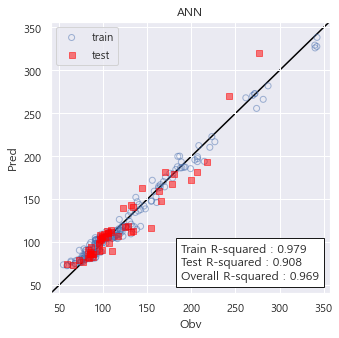

In [186]:
ann_predict = model.predict(x_test_scaled)
ann_train_predict = model.predict(x_train_scaled)

## XGBoost

make_pred_obv_plot(y_test,y_train,ann_predict,ann_train_predict,'ANN')

In [187]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train, ann_train_predict)

6.238402863434477

In [188]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, svm_predict)

12.047500862801261